In [1]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
control_folders = ['cartoons', 'general', 'memes', 'text']
anime_folders = ['furry', 'group', 'manga', 'solo']

control_imgs = []
for f in control_folders:
    control_imgs +=  ['data/' + f + '/' + x for x in os.listdir('data/' + f)]
    
anime_imgs = []
for f in anime_folders:
    anime_imgs +=  ['data/' + f + '/' + x for x in os.listdir('data/' + f)]
    
imgs = [(c, 0) for c in control_imgs] + [(c, 1) for c in anime_imgs]

print(len(control_imgs), len(anime_imgs))
print(imgs[:5], imgs[-5:])

33298 19409
[('data/cartoons/1000.png', 0), ('data/cartoons/1001.png', 0), ('data/cartoons/1002.png', 0), ('data/cartoons/1003.png', 0), ('data/cartoons/1004.png', 0)] [('data/solo/0a995.png', 1), ('data/solo/0a996.png', 1), ('data/solo/0a997.png', 1), ('data/solo/0a998.png', 1), ('data/solo/0a999.png', 1)]


In [3]:
def get_train_transform():
    return T.Compose([
#         T.RandomHorizontalFlip(p=0.5),
#         T.RandomRotation(15),
#         T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [4]:
class AnimeDataset(Dataset):
    
    def __init__(self, imgs, mode="train", transforms=None):
        
        super().__init__()
        self.imgs = [img[0] for img in imgs]
        self.labels = [img[1] for img in imgs]
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        img = Image.open(self.imgs[idx]).convert('RGB')
        img = img.resize((224, 224))
        img = self.transforms(img)
        
        if self.mode == "train" or self.mode == "val":
            return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return img
            
        
    def __len__(self):
        return len(self.imgs)

In [5]:
train_imgs, val_imgs = train_test_split(imgs, test_size=0.25)

In [6]:
train_dataset = AnimeDataset(train_imgs, mode="train", transforms=get_train_transform())
val_dataset = AnimeDataset(val_imgs, mode="val", transforms=get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 64,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 64,
    shuffle = True
)

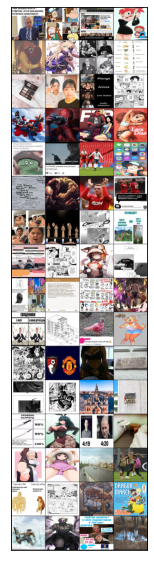

In [7]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [8]:
def accuracy(preds, trues):
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    acc = np.sum(acc) / len(preds)
    return (acc * 100)

In [9]:
def train_one_epoch(train_data_loader, optimizer, criterion):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    i = 0
    
    print("Epoch started:", len(train_data_loader), "iterations.")
    
    for images, labels in train_data_loader:
        
        if i % 50 == 0:
            print('|', end='')
        
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))
        
        optimizer.zero_grad()
        
        preds = model(images)
        
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        _loss.backward()
        optimizer.step()
        
        i += 1
        
    print()
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [10]:
def val_one_epoch(val_data_loader, best_val_acc, optimizer, criterion):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images, labels in val_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))
        
        preds = model(images)
        
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [19]:
model = resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias=True),
    nn.Sigmoid()
)

In [21]:
optimizer = torch.optim.Adam(model.parameters())
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
best_val_acc = 0
epochs = 1
for epoch in range(epochs):
    
    model.train()
    loss, acc, _time = train_one_epoch(train_data_loader, optimizer, criterion)
    
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    model.eval()
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc, optimizer, criterion)
    
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

Epoch started: 618 iterations.
|||

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


||||||||||

Training
Epoch 1
Loss : 0.241
Acc : 90.4655
Time : 569.6314

Validating
Epoch 1
Loss : 0.1825
Acc : 92.8105
Time : 192.3231


In [23]:
torch.save(model.state_dict(), "check_peter.pth")

In [24]:
loaded = resnet50(pretrained=True).to(device)

loaded.fc = nn.Sequential(
    nn.Linear(2048, 1, bias=True),
    nn.Sigmoid()
)

loaded.load_state_dict(torch.load("check_peter.pth"))

loaded

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
transformations = T.Compose([
    T.ToTensor(),
    T.Normalize((0, 0, 0),(1, 1, 1))
])

def make_prediction(img, device):
    img = img.convert("RGB")
    if img.size != (224, 224):
        img = img.resize((224, 224))
    img_tensor = transformations(img)
    return model(torch.reshape(img_tensor, (1, 3, 224, 224)).to(device))

In [26]:
make_prediction(Image.open(imgs[2][0]), device)

tensor([[0.0304]], device='cuda:0', grad_fn=<SigmoidBackward>)